In [3]:
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    

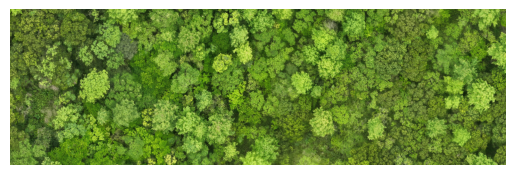

In [4]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the TIFF image
image = Image.open("h:\\Yehmh\\DNDF\\101_1_focus\\DNDF101_clip.tif")

# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()


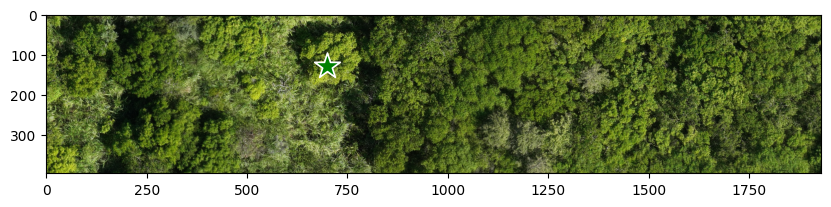

In [20]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# image = cv2.imread('g:\\2024_NDHU research assistant\\DNDF\\86_1.jpg')
image = cv2.imread('g:\\2024_NDHU research assistant\\DNDF\\86_1_clipped_image_2.tiff')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

predictor.set_image(image)

input_point = np.array([[698, 127]])
input_label = np.array([1])

plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [2]:
import rasterio

input_path = "g:\\2024_NDHU research assistant\\DNDF\\86_1_clipped_image_2.tiff"
with rasterio.open(input_path) as src:
    point1 = src.index(292362.545382, 2613034.459906)
    point2 = src.index(292339.431098, 2613032.987357)
print(point1, point2)

(127, 698) (156, 250)


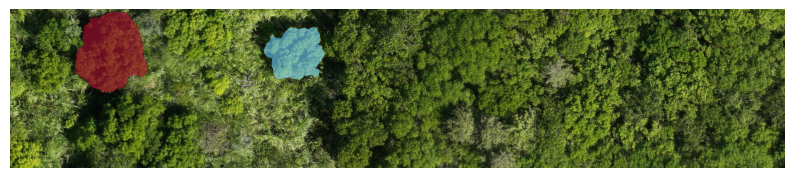

In [3]:
import numpy as np
import torch
from torchvision import transforms
import matplotlib.pyplot as plt
import cv2

import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor


sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

# device = "cuda"
device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

# image = cv2.imread('g:\\2024_NDHU research assistant\\DNDF\\86_1.jpg')
image = cv2.imread('i:\\2024_NDHU research assistant\\DNDF\\86_1_clipped_image_2.tiff')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
predictor.set_image(image)

points  = [[698, 127], [250, 156]]
input_points = np.array(points)
input_points = np.reshape(input_points, (len(points), 1, 2))
input_points = torch.tensor(input_points, device=predictor.device)

transformed_points = predictor.transform.apply_coords_torch(input_points, image.shape[:2])
transformed_labels = torch.tensor([[1] for _ in range(len(input_points))], device=predictor.device)

masks, _, _ = predictor.predict_torch(
    point_coords=transformed_points,
    point_labels=transformed_labels,
    boxes=None,
    multimask_output=False,
)

plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
plt.axis('off')
plt.show()

In [24]:
print(type(masks))
print(type(masks.cpu().numpy()))
print(masks.cpu().numpy())
print(mask[0].squeeze().shape)
print(mask[0].shape)

<class 'torch.Tensor'>
<class 'numpy.ndarray'>
[[[[False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]
   ...
   [False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]]]


 [[[False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]
   ...
   [False False False ... False False False]
   [False False False ... False False False]
   [False False False ... False False False]]]]
torch.Size([395, 1930])
torch.Size([395, 1930])


In [ ]:
import numpy as np
import cv2
import geopandas as gpd
from shapely.geometry import Polygon
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

def masks_to_polygons(masks):
    polygons = []
    for mask in masks:
        mask = mask.squeeze()
        mask_np = mask.cpu().numpy().astype(np.uint8)
        contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            contour = contour.squeeze()
            if len(contour) >= 3:  # at least 3 points to form a polygon
                polygons.append(Polygon(contour))
    return polygons

# Convert masks to polygons
polygons = masks_to_polygons(masks)

# Create a GeoDataFrame
crs = {'init': 'epsg:3826'}  # You might need to change this depending on your data
gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)

# Save to shapefile
output_shapefile = 'G:\\Yehmh\DNDF\\86_1_mask_2.shp'
gdf.to_file(output_shapefile)

In [64]:
import numpy as np
import cv2
import geopandas as gpd
from shapely.geometry import Polygon
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator
import rasterio

# Step 1: Define TM2 Transformation
def pixel_to_tm2(pixel_coords, tiff_file):
    # Open the TIFF file
    with rasterio.open(tiff_file) as src:
        # Transform pixel coordinates to map coordinates (TM2)
        tm2_coords = src.xy(pixel_coords[:, 1], pixel_coords[:, 0])
        print(tm2_coords)
        print(len(tm2_coords[0]))
        tm2_coords = np.array([tm2_coords[0], tm2_coords[1]])
        print(type(tm2_coords))
        print((tm2_coords).shape)
        tm2_coords = tm2_coords.T
        print((tm2_coords).shape)
    return tm2_coords

# Step 2: Modify masks_to_polygons function to include TM2 transformation
def masks_to_polygons(masks, tiff_file):
    polygons = []
    for mask in masks:
        print(mask.shape)
        mask = mask.squeeze()
        print(mask.shape)
        mask_np = mask.cpu().numpy().astype(np.uint8)
        contours, _ = cv2.findContours(mask_np, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        for contour in contours:
            # print(contour.shape)
            # print(contour)
            contour = contour.squeeze().reshape(-1, 2)
            # print(type(contour))
            print(contour.shape)
            # print(contour)
            if len(contour) >= 3:  # at least 3 points to form a polygon
                # Convert contour coordinates to TM2
                tm2_coords = pixel_to_tm2(contour, tiff_file)
                # Create Polygon object with TM2 coordinates
                polygons.append(Polygon(tm2_coords))
    return polygons


tiff_file = 'i:\\2024_NDHU research assistant\\DNDF\\86_1_clipped_image_2.tiff'

# Step 4: Convert masks to polygons
polygons = masks_to_polygons(masks, tiff_file)

# Step 5: Create a GeoDataFrame
crs = {'init': 'epsg:3826'}
gdf = gpd.GeoDataFrame({'geometry': polygons}, crs=crs)
print(type(gdf))
print(gdf)

# Step 6: Save to shapefile
output_shapefile = 'G:\\Yehmh\DNDF\\86_1_mask_2.shp'
gdf.to_file(output_shapefile)


torch.Size([1, 395, 1930])
torch.Size([395, 1930])
(221, 2)
([292362.56467, 292362.51304999995, 292362.40981, 292361.94522999995, 292361.89360999997, 292361.89360999997, 292361.79037, 292361.79037, 292361.58388999995, 292361.58388999995, 292361.53226999997, 292361.53226999997, 292361.48065, 292361.48065, 292361.37740999996, 292360.80958999996, 292360.75797, 292360.65472999995, 292360.29339, 292360.13853, 292360.08690999995, 292360.08690999995, 292360.03528999997, 292360.03528999997, 292359.98367, 292359.98367, 292359.93205, 292359.98367, 292359.98367, 292359.82881, 292359.77719, 292359.67394999997, 292359.62233, 292359.57071, 292359.57071, 292359.46747, 292359.46747, 292359.41585, 292359.41585, 292359.36422999995, 292359.36422999995, 292359.31260999996, 292359.31260999996, 292359.26099, 292359.26099, 292359.20937, 292359.20937, 292359.15774999995, 292359.15774999995, 292359.20937, 292359.20937, 292359.26099, 292359.26099, 292359.72556999995, 292359.88042999996, 292359.93205, 292360.086

c:\Users\CIRES\anaconda3\envs\test\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\CIRES\anaconda3\envs\test\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
